In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math 

def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find(
                'Linear') == 0) and hasattr(m, 'weight'):
            if init_type == 'gaussian':
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    return init_fun


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.double_conv.apply(weights_init('kaiming'))

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        self.maxpool_conv.apply(weights_init('kaiming'))

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        
        self.conv.apply(weights_init('kaiming'))

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv.apply(weights_init('kaiming'))
    def forward(self, x):
        return self.conv(x)
    

    """ Full assembly of the parts to form the complete network """



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024))
        self.down5 = (Down(1024,2048//factor))
        self.bottleneck = nn.Conv2d(2048//factor,2048//factor,1)
        self.up1 = (Up(2048, 1024//factor, bilinear))
        self.up2 = (Up(1024, 512//factor , bilinear))
        self.up3 = (Up(512, 256//factor, bilinear))
        self.up4 = (Up(256, 128//factor, bilinear))
        self.up5 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.bottleneck(x6)
        x = self.up1(x7, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return logits

    # def use_checkpointing(self):
    #     self.inc = torch.utils.checkpoint(self.inc)
    #     self.down1 = torch.utils.checkpoint(self.down1)
    #     self.down2 = torch.utils.checkpoint(self.down2)
    #     self.down3 = torch.utils.checkpoint(self.down3)
    #     self.down4 = torch.utils.checkpoint(self.down4)
    #     self.up1 = torch.utils.checkpoint(self.up1)
    #     self.up2 = torch.utils.checkpoint(self.up2)
    #     self.up3 = torch.utils.checkpoint(self.up3)
    #     self.up4 = torch.utils.checkpoint(self.up4)
    #     self.outc = torch.utils.checkpoint(self.outc)

In [26]:
from torchsummary import summary

model = UNet(3,3,bilinear = True)

summary(model, (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,728
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,456
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

In [104]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd 
from torchvision import transforms


def create_random_mask(min_size, max_size, image_size):
    mask_size = torch.randint(min_size, max_size + 1, (2,))
    x = torch.randint(0, image_size[0] - mask_size[0], (1,))
    y = torch.randint(0, image_size[1] - mask_size[1], (1,))
    mask = torch.ones(image_size)
    mask[x[0]:x[0]+mask_size[0], y[0]:y[0]+mask_size[1]] = 0
    return mask

class dataset(Dataset):
    def __init__(self, csv_path, image_size = 512, mask_min_size = 60, mask_max_size = 200):
        csv = pd.read_csv(csv_path)
        self.images = csv['images'].values
        self.image_size = image_size
        self.mask_min_size = mask_min_size
        self.mask_max_size = mask_max_size
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        mask = create_random_mask(self.mask_min_size, self.mask_max_size, (self.image_size,self.image_size))
        image = self.transform(Image.open(self.images[idx]))
        masked_image = mask*image 
        return masked_image, mask, image

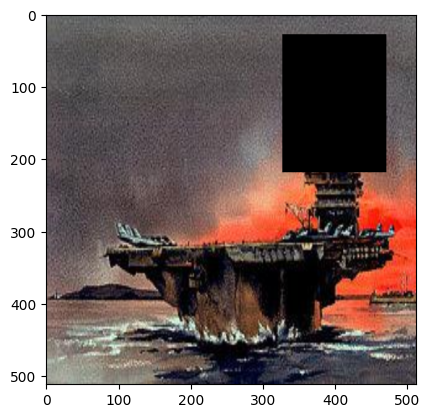

In [105]:
from matplotlib import pyplot as plt

masked_image, mask, image = dataset('data/painting_train.csv').__getitem__(1)

plt.imshow(masked_image.permute(1,2,0))

In [92]:
import torch 
mask = create_random_mask(40,150, (512,512))

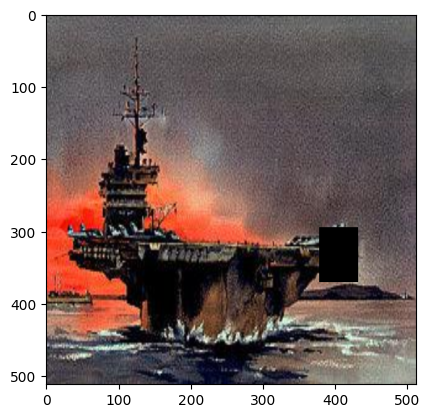

In [94]:
plt.imshow((img*(mask)).permute(1,2,0))

In [ ]:
from torchvision import models
import torch
from torch import nn
from torch.nn import functional as F

class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)

        self.enc_1 = nn.Sequential(*vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{:d}'.format(i + 1)).parameters():
                param.requires_grad = False

    def forward(self, image):
        results = [image]
        for i in range(3):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]
    

def gram_matrix(feat):
    # https://github.com/pytorch/examples/blob/master/fast_neural_style/neural_style/utils.py
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram


def total_variation_loss(image):
    # shift one pixel and get difference (for both x and y direction)
    loss = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
        torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return loss

class InpaintingLoss(nn.Module):
    def __init__(self, extractor=VGG16FeatureExtractor()):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.extractor = extractor

    def forward(self, mask, output, gt):
        loss_dict = {}
        loss_dict['hole'] = self.l1((1 - mask) * output, (1 - mask) * gt)
        loss_dict['valid'] = self.l1(mask * output, mask * gt)
        feat_output = self.extractor(output)
        feat_gt = self.extractor(gt)
        loss_dict['prc'] = 0.0
        for i in range(3):
            loss_dict['prc'] += self.l1(feat_output[i], feat_gt[i])
        loss_dict['style'] = 0.0
        for i in range(3):
            loss_dict['style'] += self.l1(gram_matrix(feat_output[i]),
                                          gram_matrix(feat_gt[i]))

        # loss_dict['tv'] = total_variation_loss(output_comp)
            
        return loss_dict

In [ ]:
InpaintingLoss()